# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Water Potability Prediction</b></div>

In [156]:
# Importation des bibliothèques de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


# Métriques d'évaluation
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')


In [141]:
dataset = pd.read_csv('water-dataset.csv')

In [142]:
dataset.head()

,pH,Turbidity,Chlorine,Dissolved Oxygen,Temperature,Potability
0,7.45,15.60,0.70,7.56,50,False
1,7.83,2.41,0.77,7.58,0,True
2,8.09,2.57,0.58,7.29,50,True
3,7.16,1.19,0.53,7.83,25,True
4,7.59,4.29,0.58,7.98,25,True


In [24]:
print(f" - Nombre de lignes: {dataset.shape[0]}")
print(f" - Nombre de colonnes: {dataset.shape[1]}")

 - Nombre de lignes: 5000
 - Nombre de colonnes: 6


In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                5000 non-null   float64
 1   Turbidity         5000 non-null   float64
 2   Chlorine          5000 non-null   float64
 3   Dissolved Oxygen  5000 non-null   float64
 4   Temperature       5000 non-null   int64  
 5   Potability        5000 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 200.3 KB


In [26]:
dataset.describe()

,pH,Turbidity,Chlorine,Dissolved Oxygen,Temperature
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,7.565512,3.154142,0.932878,7.342220,24.735000
std,0.851572,1.772466,1.532965,1.004724,20.399461
min,6.100000,1.000000,0.500000,6.500000,0.000000
25%,7.010000,2.020000,0.630000,6.880000,0.000000
50%,7.510000,3.030000,0.750000,7.250000,25.000000
75%,8.020000,4.040000,0.880000,7.620000,50.000000
max,13.970000,19.720000,19.920000,19.940000,50.000000


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> EDA </b></div>

In [27]:
dataset.duplicated().sum()

np.int64(0)

In [28]:
missing = dataset.isnull().sum()
missing

pH                  0
Turbidity           0
Chlorine            0
Dissolved Oxygen    0
Temperature         0
Potability          0
dtype: int64

Potability
True     4615
False     385
Name: count, dtype: int64


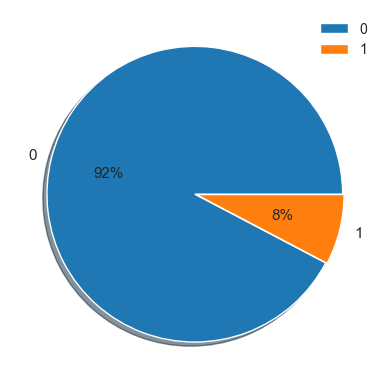

In [146]:
target = dataset['Potability'].value_counts()
print(target)
plt.pie(target, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.show()

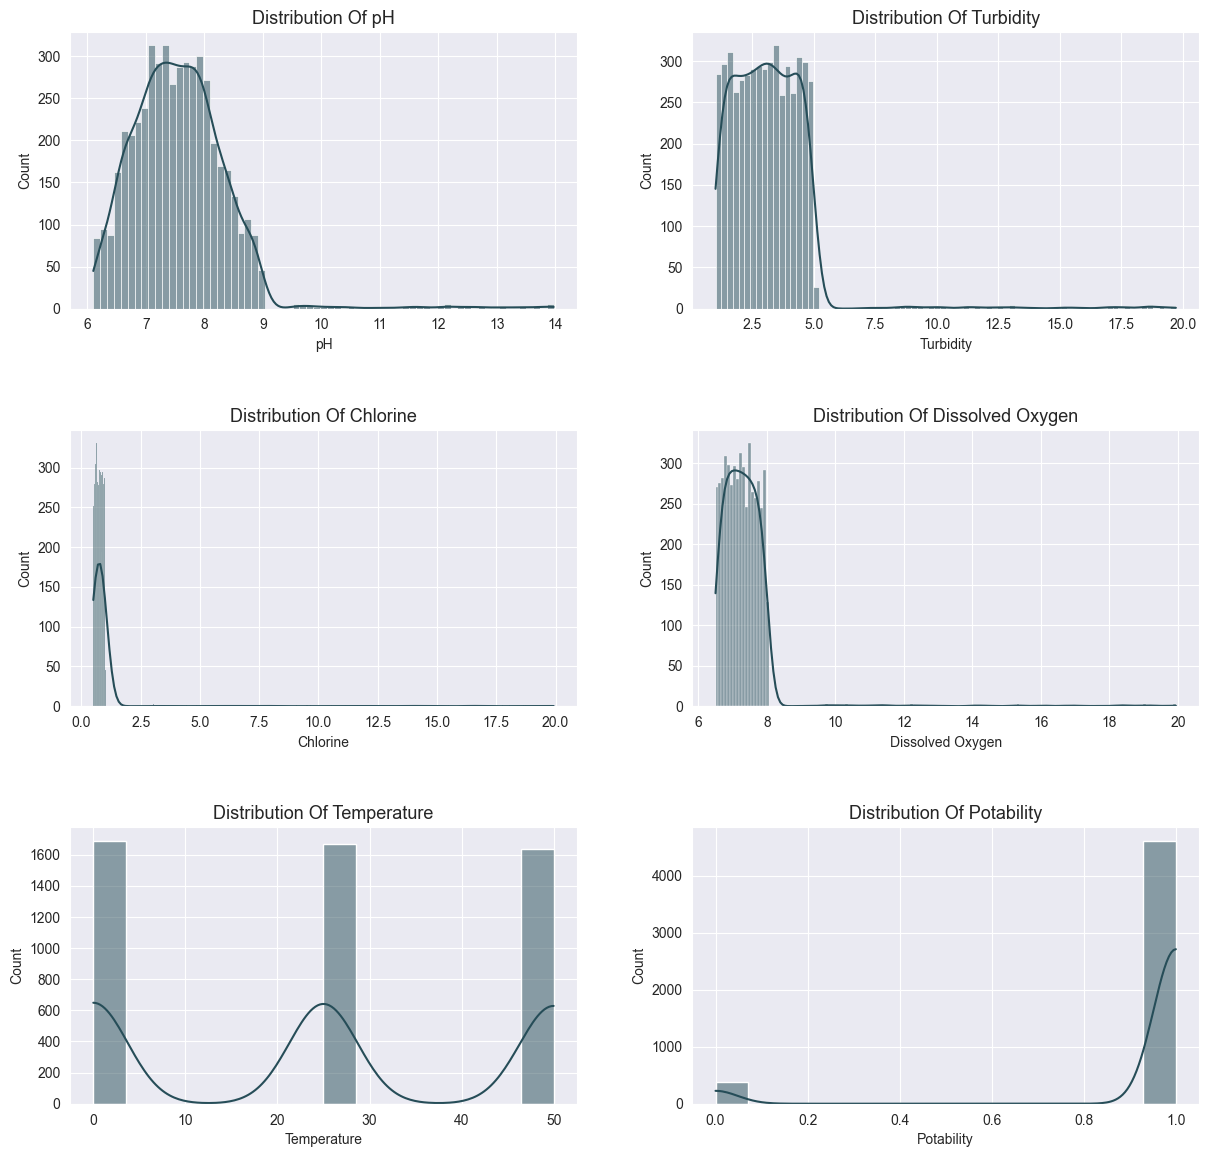

In [31]:
plt.figure(figsize=(13,20))
for k, cols in enumerate(dataset):
    plt.subplot(5,2, k+1)
    sns.histplot(x=cols,data=dataset, color='#264D58', kde=True)
    plt.title(f"Distribution Of {cols}", fontsize=13)
    plt.tight_layout(pad=4.0)
    
plt.show()

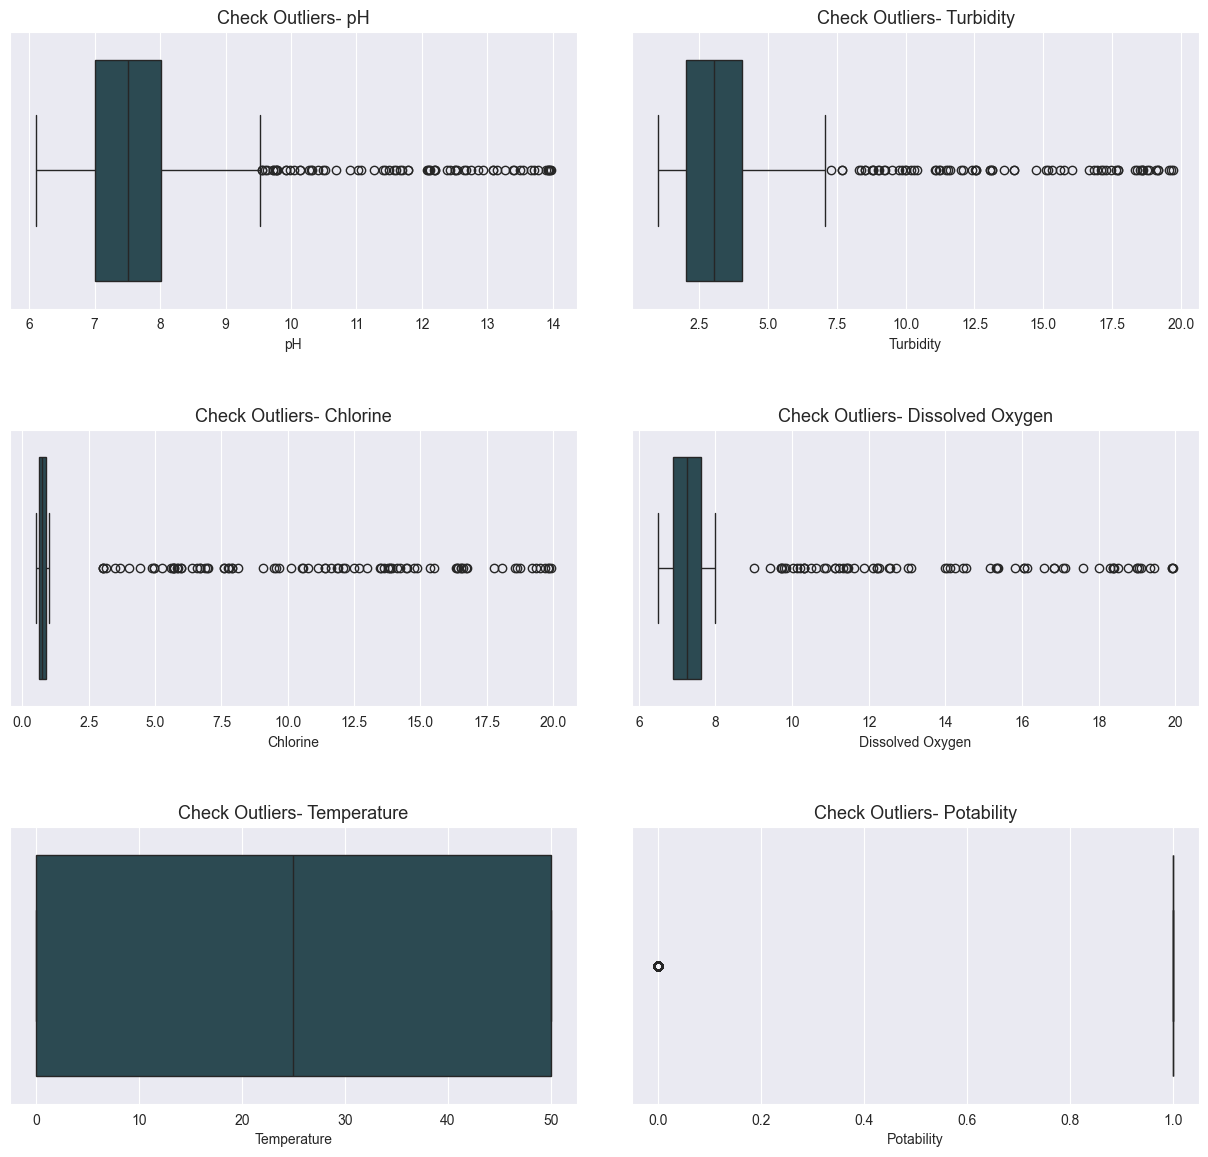

In [32]:
plt.figure(figsize=(13,20))
for k, cols in enumerate(dataset):
    plt.subplot(5,2, k+1)
    sns.boxplot(x=cols,data=dataset, color='#264D58')
    plt.title(f"Check Outliers- {cols}", fontsize=13)
    plt.tight_layout(pad=4.0)
    
plt.show()

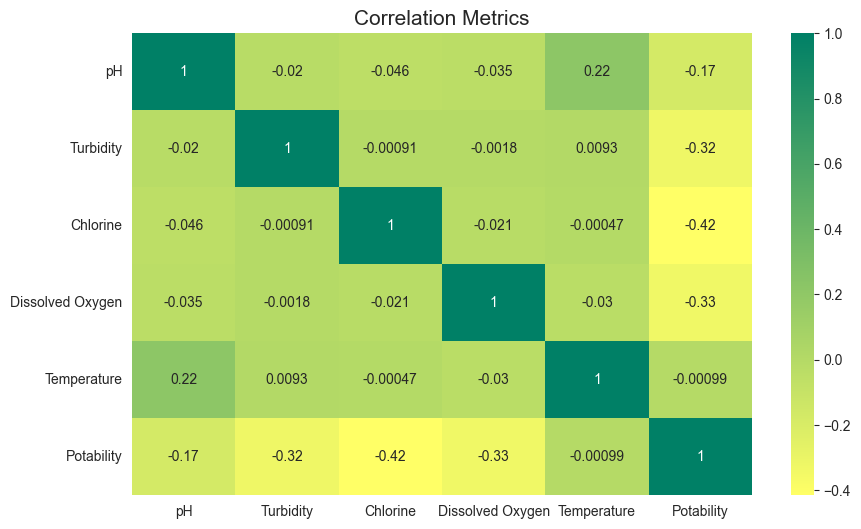

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(), annot=True, cmap='summer_r')
plt.title('Correlation Metrics', fontsize=15)
plt.show()

In [34]:
# Convertir en numérique (1=Potable, 0=Non-Potable)
dataset['Potability_numeric'] = dataset['Potability'].astype(int)

In [35]:
features = ['pH', 'Turbidity', 'Chlorine', 'Dissolved Oxygen', 'Temperature']
X = dataset[features]
y = dataset['Potability_numeric']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, 
                                                      stratify=y)

In [39]:
from collections import Counter
print(f"   Train: {X_train.shape[0]} ({Counter(y_train)[1]} potable, {Counter(y_train)[0]} non-potable)")
print(f"   Test:  {X_test.shape[0]} ({Counter(y_test)[1]} potable, {Counter(y_test)[0]} non-potable)")


   Train: 4000 (3692 potable, 308 non-potable)
   Test:  1000 (923 potable, 77 non-potable)


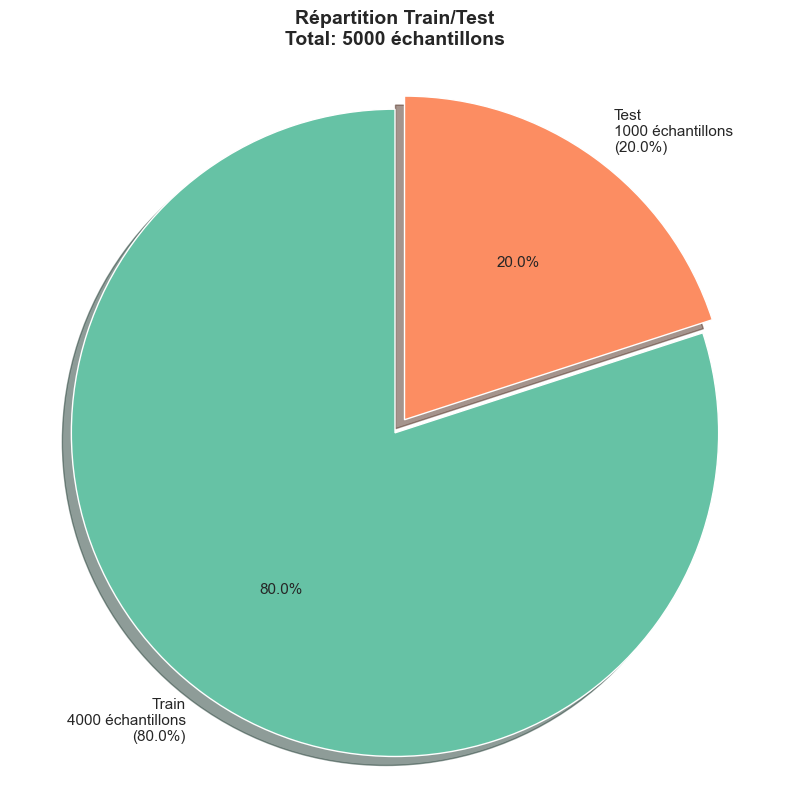

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Calculer les tailles
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size

# Calculer les pourcentages
train_pct = (train_size / total_size) * 100
test_pct = (test_size / total_size) * 100

# Créer le diagramme circulaire
plt.figure(figsize=(8, 8))
sizes = [train_pct, test_pct]
labels = [f'Train\n{train_size} échantillons\n({train_pct:.1f}%)', 
          f'Test\n{test_size} échantillons\n({test_pct:.1f}%)']
colors = ['#66c2a5', '#fc8d62']
explode = (0.05, 0)  # Détacher légèrement le premier segment

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90, shadow=True,
        textprops={'fontsize': 11})

plt.title(f'Répartition Train/Test\nTotal: {total_size} échantillons', 
          fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')  # Assure que le pie chart est un cercle
plt.tight_layout()
plt.savefig('repartition_train_test.png', dpi=300, bbox_inches='tight')
plt.show()



# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Scaling Data </b></div>

In [44]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   - X_train_scaled: {X_train_scaled.shape}")
print(f"   - X_test_scaled: {X_test_scaled.shape}")

   - X_train_scaled: (4000, 5)
   - X_test_scaled: (1000, 5)


In [45]:
# Convertir en DataFrame pour affichage
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

In [46]:
print(f"\n Statistiques APRÈS normalisation (X_train_scaled):")
print(X_train_scaled_df.describe().round(2))


 Statistiques APRÈS normalisation (X_train_scaled):
            pH  Turbidity  Chlorine  Dissolved Oxygen  Temperature
count  4000.00    4000.00   4000.00           4000.00      4000.00
mean     -0.00      -0.00      0.00              0.00         0.00
std       1.00       1.00      1.00              1.00         1.00
min      -1.75      -1.19     -0.28             -0.83        -1.21
25%      -0.65      -0.62     -0.19             -0.46        -1.21
50%      -0.05      -0.07     -0.12             -0.10         0.01
75%       0.55       0.47     -0.03              0.28         1.23
max       7.67       9.03     12.43             12.47         1.23


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Models Building</b></div>

In [147]:
y_anomaly =  y_test.copy()
y_anomaly = y_anomaly.replace({0: -1, 1: 1})  

In [148]:
# Calculer le taux de contamination (proportion d'anomalies)
contamination_rate = (y_train == 0).sum() / len(y_train)
print(f"Taux de contamination : {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")

Taux de contamination : 0.0780 (7.80%)


In [ ]:

anomaly_models = {
    'Isolation Forest': IsolationForest(
        contamination=contamination_rate,
        random_state=42,
        n_estimators=100
    ),
    'One-Class SVM': OneClassSVM(
        nu=contamination_rate,
        kernel='rbf',
        gamma='auto'
    ),
    'Local Outlier Factor': LocalOutlierFactor(
        contamination=contamination_rate,
        novelty=True,        
        n_neighbors=20
    )
}


In [ ]:
anomaly_results = {}
for name, model in anomaly_models.items():
    print(f"\n {name}...")

    # Entraînement + prédiction
    model.fit(X_train_scaled)
    y_pred_anomaly = model.predict(X_test_scaled)   

    # Accuracy 
    accuracy = accuracy_score(y_anomaly, y_pred_anomaly)

    # Conversion vers (0 / 1)
    y_pred_binary = [0 if p == -1 else 1 for p in y_pred_anomaly]
    y_true_binary = [0 if t == -1 else 1 for t in y_anomaly]

    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    # Anomalies détectées
    anomalies_detected = (y_pred_anomaly == -1).sum()

    anomaly_results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'anomalies_detected': anomalies_detected,
        'y_pred': y_pred_anomaly

    }
    print("Accuracy :", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall   :", round(recall, 3))
    print("F1-score :", round(f1, 3))
    print(f"      - Anomalies détectées sur test: {anomalies_detected}/{len(y_test)}")
    print(f"      - TN: {cm[0][0]:3d} | FP: {cm[0][1]:3d} | FN: {cm[1][0]:3d} | TP: {cm[1][1]:3d}")




 Isolation Forest...
Accuracy : 0.865
Precision: 0.93
Recall   : 0.924
F1-score : 0.927
      - Anomalies détectées sur test: 78/1000
      - TN:   8 | FP:  65 | FN:  70 | TP: 857

 One-Class SVM...
Accuracy : 0.861
Precision: 0.928
Recall   : 0.921
F1-score : 0.925
      - Anomalies détectées sur test: 80/1000
      - TN:   7 | FP:  66 | FN:  73 | TP: 854

 Local Outlier Factor...
Accuracy : 0.848
Precision: 0.924
Recall   : 0.91
F1-score : 0.917
      - Anomalies détectées sur test: 87/1000
      - TN:   4 | FP:  69 | FN:  83 | TP: 844


In [ ]:
# DataFrame 
anomaly_comparison = pd.DataFrame({
    'Model': list(anomaly_results.keys()),
    'Accuracy': [anomaly_results[model]['accuracy'] for model in anomaly_results.keys()],
    'Precision': [anomaly_results[model]['precision'] for model in anomaly_results.keys()],
    'Recall': [anomaly_results[model]['recall'] for model in anomaly_results.keys()],
    'F1-Score': [anomaly_results[model]['f1_score'] for model in anomaly_results.keys()]
})


In [104]:
# Trier par F1-Score
anomaly_comparison = anomaly_comparison.sort_values('F1-Score', ascending=False)

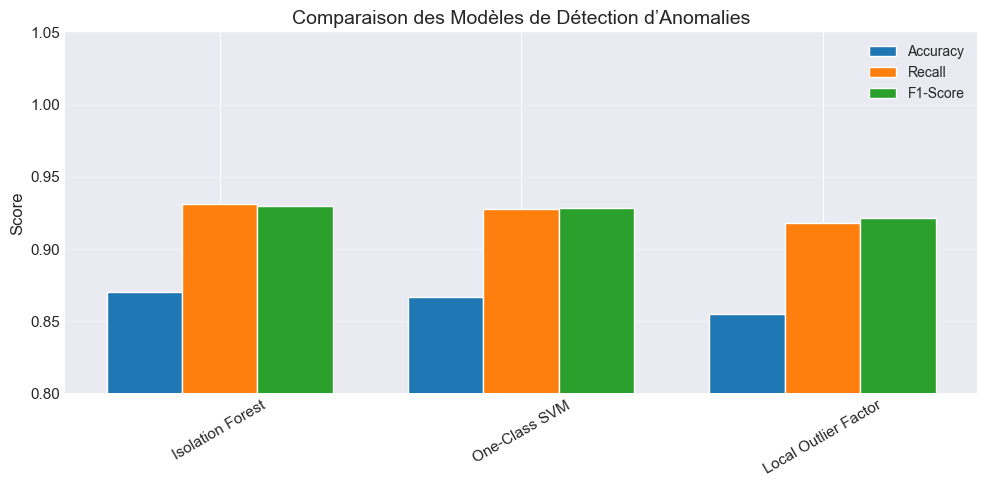

In [152]:
plt.figure(figsize=(10, 5))

x = np.arange(len(anomaly_comparison))
width = 0.25

plt.bar(x - width, anomaly_comparison['Accuracy'], width, label='Accuracy')
plt.bar(x, anomaly_comparison['Recall'], width, label='Recall')
plt.bar(x + width, anomaly_comparison['F1-Score'], width, label='F1-Score')

plt.xticks(x, anomaly_comparison['Model'], rotation=30)
plt.ylabel('Score')
plt.title('Comparaison des Modèles de Détection d’Anomalies')
plt.ylim(0.8, 1.05)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


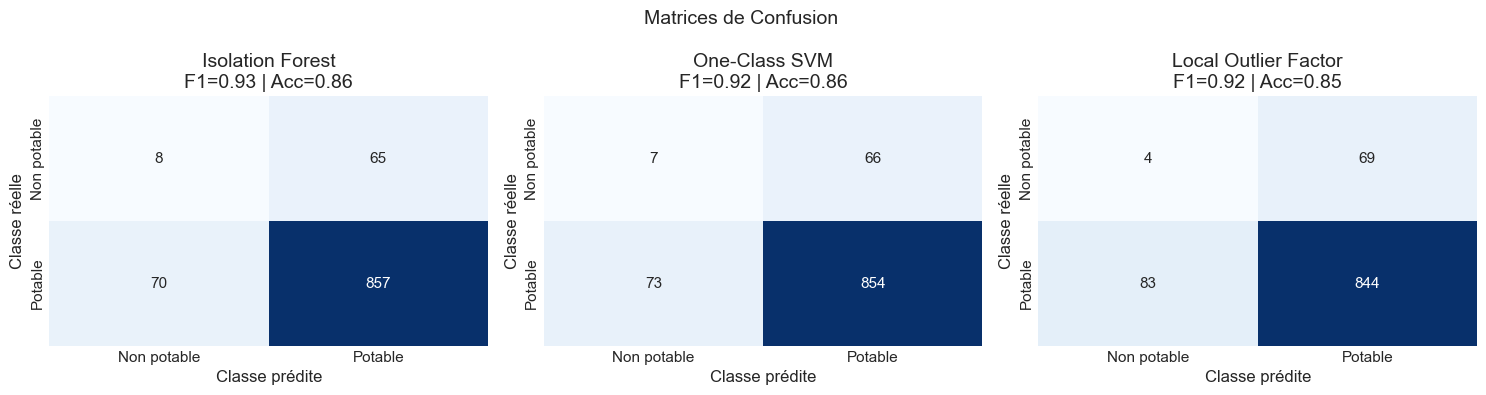

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
plt.suptitle("Matrices de Confusion ", fontsize=14)

for ax, (name, res) in zip(axes, anomaly_results.items()):
    sns.heatmap(
        res['confusion_matrix'],
        annot=True, fmt='d', cmap='Blues',
        xticklabels=['Non potable', 'Potable'],
        yticklabels=['Non potable', 'Potable'],
        cbar=False, ax=ax
    )
    ax.set_title(f"{name}\nF1={res['f1_score']:.2f} | Acc={res['accuracy']:.2f}")
    ax.set_xlabel("Classe prédite")
    ax.set_ylabel("Classe réelle")

plt.tight_layout()
plt.show()


In [ ]:
# meilleur modèle 
best_model_name = max(anomaly_results, key=lambda x: anomaly_results[x]['f1_score'])
best_model_info = anomaly_results[best_model_name]

print(f"\nMeilleur modèle détecteur d'anomalies: {best_model_name}")



Meilleur modèle détecteur d'anomalies: Isolation Forest


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Test </b></div>

In [167]:
reference_stats = {}
for feature in ['pH', 'Turbidity', 'Chlorine', 'Dissolved Oxygen', 'Temperature']:
    reference_stats[feature] = {
        'mean': dataset[feature].mean(),
        'std': dataset[feature].std(),
        'min': dataset[feature].quantile(0.05),
        'max': dataset[feature].quantile(0.95),
        'q1': dataset[feature].quantile(0.25),
        'q3': dataset[feature].quantile(0.75)
    }


# Fonction d'analyse
def analyser_features_anormales(pH, Turbidity, Chlorine, Dissolved_Oxygen, Temperature, description=""):
   
    # Créer l'échantillon
    sample = pd.DataFrame({
        'pH': [pH],
        'Turbidity': [Turbidity],
        'Chlorine': [Chlorine],
        'Dissolved Oxygen': [Dissolved_Oxygen],
        'Temperature': [Temperature]
    })
    
    # Normaliser 
    sample_scaled = scaler.transform(sample)
    
    # Prédire avec Isolation Forest 
    best_model = anomaly_models['Isolation Forest'] 
    prediction = best_model.predict(sample_scaled)[0]
    score = best_model.decision_function(sample_scaled)[0]
    
    # Analyse par feature
    features_analysis = {}
    anomalies_detected = []
    
    values = {
        'pH': pH,
        'Turbidity': Turbidity,
        'Chlorine': Chlorine,
        'Dissolved Oxygen': Dissolved_Oxygen,
        'Temperature': Temperature
    }
    
    for feature, value in values.items():
        stats = reference_stats[feature]
        z_score = (value - stats['mean']) / stats['std']
        
        is_outlier_iqr = value < (stats['q1'] - 1.5*(stats['q3']-stats['q1'])) or \
                         value > (stats['q3'] + 1.5*(stats['q3']-stats['q1']))
        is_extreme = abs(z_score) > 2
        is_very_extreme = abs(z_score) > 3
        
        if is_very_extreme:
            status = "🔴 TRÈS ANORMAL"
            anomalies_detected.append((feature, "TRÈS ANORMAL", z_score))
        elif is_extreme:
            status = "🟠 ANORMAL"
            anomalies_detected.append((feature, "ANORMAL", z_score))
        elif is_outlier_iqr:
            status = "🟡 SUSPECT"
            anomalies_detected.append((feature, "SUSPECT", z_score))
        else:
            status = "🟢 NORMAL"
        
        features_analysis[feature] = {
            'value': value,
            'mean': stats['mean'],
            'std': stats['std'],
            'z_score': z_score,
            'status': status,
            'range': f"[{stats['min']:.2f} - {stats['max']:.2f}]"
        }
    
    # resultats

    if description:
        print(f" {description}")
    
    print(f"\n PARAMÈTRES DE L'ÉCHANTILLON:")
    print(f"{'Feature':<20} {'Valeur':<12} {'Moyenne':<12} {'Z-Score':<12} {'Statut':<20}")
    print("-"*80)
    for feature, analysis in features_analysis.items():
        print(f"{feature:<20} {analysis['value']:<12.2f} {analysis['mean']:<12.2f} "
              f"{analysis['z_score']:<12.2f} {analysis['status']:<20}")
    
    print("\n ANALYSE DES ANOMALIES PAR FEATURE:")
    print("-"*80)
    if anomalies_detected:
        print(f"\n  {len(anomalies_detected)} feature(s) anormale(s) détectée(s):\n")
        for i, (feature, severity, z_score) in enumerate(anomalies_detected, 1):
            analysis = features_analysis[feature]
            direction = f"TROP ÉLEVÉ (+{z_score:.2f}σ)" if z_score > 0 else f"TROP BAS ({z_score:.2f}σ)"
            print(f"   {i}. {feature}:")
            print(f"      • Valeur: {analysis['value']:.2f}")
            print(f"      • Moyenne normale: {analysis['mean']:.2f}")
            print(f"      • Plage normale (95%): {analysis['range']}")
            print(f"      • Diagnostic: {direction}")
            print(f"      • Sévérité: {severity}\n")
    else:
        print("   Aucune anomalie détectée dans les features individuelles")
    
    print("\n RÉSULTAT ISOLATION FOREST:")
    print("-"*80)
    print(f"   • Score d'anomalie: {score:.4f}")
    confidence = "Tres haute" if score>0.1 else "Haute" if score>0 else "Modérée" if score>-0.05 else "Faible"
    print(f"   • Confiance: {confidence}")
    
    print(f"\n resultats FINAL:")
    if prediction == 1:
        print(f"   EAU POTABLE")
        if anomalies_detected:
            print(f"   Note: Malgré {len(anomalies_detected)} feature(s) suspecte(s), le modèle considère l'ensemble comme POTABLE")
    else:
        print(f"  EAU NON POTABLE")
    return prediction, score, anomalies_detected

# TEST 1: Eau normale
analyser_features_anormales(
    pH=7.5, 
    Turbidity=3.0, 
    Chlorine=0.75, 
    Dissolved_Oxygen=7.5, 
    Temperature=25,
)



 PARAMÈTRES DE L'ÉCHANTILLON:
Feature              Valeur       Moyenne      Z-Score      Statut              
--------------------------------------------------------------------------------
pH                   7.50         7.57         -0.08        🟢 NORMAL            
Turbidity            3.00         3.15         -0.09        🟢 NORMAL            
Chlorine             0.75         0.93         -0.12        🟢 NORMAL            
Dissolved Oxygen     7.50         7.34         0.16         🟢 NORMAL            
Temperature          25.00        24.73        0.01         🟢 NORMAL            

 ANALYSE DES ANOMALIES PAR FEATURE:
--------------------------------------------------------------------------------
   Aucune anomalie détectée dans les features individuelles

 RÉSULTAT ISOLATION FOREST:
--------------------------------------------------------------------------------
   • Score d'anomalie: 0.0890
   • Confiance: Haute

 resultats FINAL:
   EAU POTABLE


(np.int64(1), np.float64(0.08904820535580354), [])

In [155]:
# TEST 2: Turbidité très élevée
analyser_features_anormales(
    pH=7.5, 
    Turbidity=18.0, 
    Chlorine=0.7, 
    Dissolved_Oxygen=7.5, 
    Temperature=50,
)



 PARAMÈTRES DE L'ÉCHANTILLON:
Feature              Valeur       Moyenne      Z-Score      Statut              
--------------------------------------------------------------------------------
pH                   7.50         7.57         -0.08        🟢 NORMAL            
Turbidity            18.00        3.15         8.38         🔴 TRÈS ANORMAL      
Chlorine             0.70         0.93         -0.15        🟢 NORMAL            
Dissolved Oxygen     7.50         7.34         0.16         🟢 NORMAL            
Temperature          50.00        24.73        1.24         🟢 NORMAL            

 ANALYSE DES ANOMALIES PAR FEATURE:
--------------------------------------------------------------------------------

  1 feature(s) anormale(s) détectée(s):

   1. Turbidity:
      • Valeur: 18.00
      • Moyenne normale: 3.15
      • Plage normale (95%): [1.21 - 4.84]
      • Diagnostic: TROP ÉLEVÉ (+8.38σ)
      • Sévérité: TRÈS ANORMAL


 RÉSULTAT ISOLATION FOREST:
----------------------------

(np.int64(-1),
 np.float64(-0.13512872624709948),
 [('Turbidity', 'TRÈS ANORMAL', np.float64(8.375823124782602))])